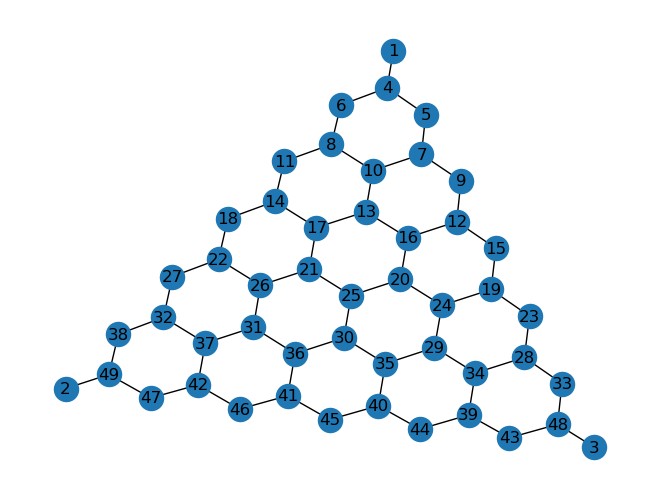

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# choice points <6 hexes away from ports
ILLEGAL_CHOICE_POINTS = [4, 6, 5, 11, 8, 10, 7, 9, 49, 38, 47, 32, 42, 27, 37, 46, 48, 43, 33, 39, 28, 44, 34, 23]

# Create an empty graph
G_original = nx.Graph()

# Function to add edges to a node (works even if the node doesn't exist yet!)
def add_edges_to_node(graph, node, edges):
    for edge in edges:
        graph.add_edge(node, edge)
        
def find_all_critical_choice_points(graph):
    paths12 = list(nx.all_shortest_paths(G, source=1, target=2))
    paths13 = list(nx.all_shortest_paths(G, source=1, target=3))
    paths23 = list(nx.all_shortest_paths(G, source=2, target=3))
    
    choice_points = set()
    # all choice points from port 1
    for path_a in paths12:
        for path_b in paths13:
            shared_path = [hex for hex in path_a if hex in path_b]
            choice_points.add(shared_path[-1])
    
    # all choice points from port 2
    for path_a in paths12:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b]
            choice_points.add(shared_path[-1])
            
    # all choice points from port 3
    for path_a in paths13:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b[::-1]]
            choice_points.add(shared_path[-1])
    return choice_points

# Define all nodes and edges to create the empty maze
add_edges_to_node(G_original, 1, [4])
add_edges_to_node(G_original, 4, [1, 5, 6])
add_edges_to_node(G_original, 6, [4, 8])
add_edges_to_node(G_original, 5, [4, 7])
add_edges_to_node(G_original, 8, [6, 11, 10])
add_edges_to_node(G_original, 7, [5, 10, 9])
add_edges_to_node(G_original, 11, [8, 14])
add_edges_to_node(G_original, 10, [8, 7, 13])
add_edges_to_node(G_original, 9, [7, 12])
add_edges_to_node(G_original, 14, [11, 18, 17])
add_edges_to_node(G_original, 13, [10, 17, 16])
add_edges_to_node(G_original, 12, [9, 16, 15])
add_edges_to_node(G_original, 18, [14, 22])
add_edges_to_node(G_original, 17, [14, 13, 21])
add_edges_to_node(G_original, 16, [13, 12, 20])
add_edges_to_node(G_original, 15, [12, 19])
add_edges_to_node(G_original, 22, [18, 27, 26])
add_edges_to_node(G_original, 21, [17, 26, 25])
add_edges_to_node(G_original, 20, [16, 25, 24])
add_edges_to_node(G_original, 19, [15, 24, 23])
add_edges_to_node(G_original, 27, [22, 32])
add_edges_to_node(G_original, 26, [22, 21, 31])
add_edges_to_node(G_original, 25, [21, 20, 30])
add_edges_to_node(G_original, 24, [20, 19, 29])
add_edges_to_node(G_original, 23, [19, 28])
add_edges_to_node(G_original, 32, [27, 38, 37])
add_edges_to_node(G_original, 31, [26, 37, 36])
add_edges_to_node(G_original, 30, [25, 36, 35])
add_edges_to_node(G_original, 29, [24, 35, 34])
add_edges_to_node(G_original, 28, [23, 34, 33])
add_edges_to_node(G_original, 38, [32, 49])
add_edges_to_node(G_original, 37, [31, 32, 42])
add_edges_to_node(G_original, 36, [30, 31, 41])
add_edges_to_node(G_original, 35, [29, 30, 40])
add_edges_to_node(G_original, 34, [28, 29, 39])
add_edges_to_node(G_original, 33, [28, 48])
add_edges_to_node(G_original, 49, [2, 38, 47])
add_edges_to_node(G_original, 42, [37, 46, 47])
add_edges_to_node(G_original, 41, [36, 45, 46])
add_edges_to_node(G_original, 40, [35, 44, 45])
add_edges_to_node(G_original, 39, [34, 43, 44])
add_edges_to_node(G_original, 48, [3, 33, 43])
add_edges_to_node(G_original, 2, [49])
add_edges_to_node(G_original, 47, [49, 42])
add_edges_to_node(G_original, 46, [42, 41])
add_edges_to_node(G_original, 45, [41, 40])
add_edges_to_node(G_original, 44, [40, 39])
add_edges_to_node(G_original, 43, [39, 48])
add_edges_to_node(G_original, 3, [48])

# Draw the original graph
nx.draw_kamada_kawai(G_original, with_labels=True)
plt.show()

All possible hexes we could put a barrier:
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 34 35 36 37 39 40 41 42 44 45 46]
Barriers we randomly selected:
[15 18 36 31 46 22 19 29 17]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[18 42  9 14 23 29 21 15 36]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[31 12 23 27 41 25 19 44 39]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[10 34 12 46 42 37 21  8 18]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[34 31 40 29 37 41 16 17 39]
BAD MAZE: Path between reward ports is too short (<=13)
Barriers we randomly selected:
[14 29 37 41 10 18 36 30 22]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[11 45 25 44 21  8 29 36 46]
BAD MAZE: Path between reward ports is too short (<=13)
Barriers we randomly selected:
[41 16 28 14 27

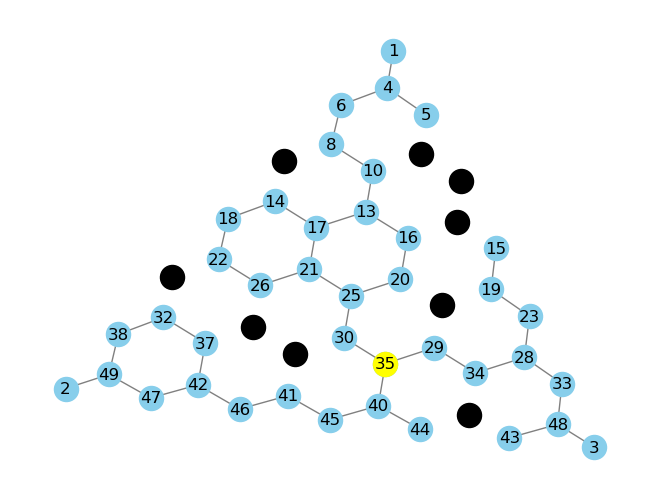

In [81]:
# test choosing where to put the barriers

def is_valid_maze(graph):
    # Make sure all ports are reachable
    if not nx.has_path(graph, 1, 2) or not nx.has_path(graph, 1, 3) or not nx.has_path(graph, 2, 3):
        print("BAD MAZE: At least one reward port is not reachable!")
        return False
    
    # Make sure path lengths are between 15-25
    len12 = nx.shortest_path_length(G, source=1, target=2)
    len13 = nx.shortest_path_length(G, source=1, target=3)
    len23 = nx.shortest_path_length(G, source=2, target=3)
    reward_port_lengths = [len12, len13, len23]
    if min(reward_port_lengths) <= 13:
        print("BAD MAZE: Path between reward ports is too short (<=13)")
        return False
    if max(reward_port_lengths) - min(reward_port_lengths) < 4:
        print("BAD MAZE: Distance difference in reward port paths is too small (<4)")
        return False
    if max(reward_port_lengths) > 25:
        print("BAD MAZE: Path between reward ports is too long (>25)")
        return False
    
    # Make sure there are no "islands" of unconnected hexes
    if not nx.is_connected(G):
        # If not connected, get each separate component
        connected_components = list(nx.connected_components(G))
        for component in connected_components:
            if 3 <= len(component) <= 35:
                print("BAD MAZE: Group of >2 inaccessible hexes")
                return False
            
    # Make sure critical choice point is >=4 away from port
    choice_points = find_all_critical_choice_points(G)
    if any(hex in ILLEGAL_CHOICE_POINTS for hex in choice_points):
        print("BAD MAZE: Choice point <6 hexes away from reward port")
        return False
    
    return True

# Generate a range from 5-47
possible_barriers = np.arange(5, 48)
# Exclude barriers right next to ports
barriers_to_exclude = [5, 6, 33, 38, 43, 47]
possible_barriers = possible_barriers[~np.isin(possible_barriers, barriers_to_exclude)]

print("All possible hexes we could put a barrier:")
print(possible_barriers)

is_good_maze = False

# generate random barriers until we get good ones
while not is_good_maze:
    # create copy of original graph to mess with
    G = G_original.copy()

    # Randomly select 9 barriers
    barriers = np.random.choice(possible_barriers, size=9, replace=False)
    print("Barriers we randomly selected:")
    print(barriers)
    
    # now remove those from our graph!
    for barrier in barriers:
        G.remove_node(barrier)

    is_good_maze = is_valid_maze(G)

# Tell us about our maze
print("Shortest path between 1 and 2:", nx.shortest_path(G, source=1, target=2))
print("Length of path:", len(nx.shortest_path(G, source=1, target=2)))

print("Shortest path between 1 and 3:", nx.shortest_path(G, source=1, target=3))
print("Length of path:", len(nx.shortest_path(G, source=1, target=3)))

print("Shortest path between 2 and 3:", nx.shortest_path(G, source=2, target=3))
print("Length of path:", len(nx.shortest_path(G, source=2, target=3)))

print("Choice points:")
choice_points = find_all_critical_choice_points(G)
print(choice_points)

# Get the graph layout of the original maze
pos = nx.kamada_kawai_layout(G_original)

# Draw the open hexes using this layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')

# Add the barriers in black
for barrier in barriers:
        nx.draw_networkx_nodes(G_original, pos, nodelist=[barrier], node_color='black')

# Make the choice points yellow
for choice_point in choice_points:
        nx.draw_networkx_nodes(G_original, pos, nodelist=[choice_point], node_color='yellow')
        
plt.show()

24
